<a href="https://colab.research.google.com/github/Ayush-Sharma15/Zeotap/blob/main/Ayush_Sharma_Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV files
customers_df = pd.read_csv("https://raw.githubusercontent.com/Ayush-Sharma15/Zeotap/refs/heads/main/Customers.csv")
products_df = pd.read_csv("https://raw.githubusercontent.com/Ayush-Sharma15/Zeotap/refs/heads/main/Products.csv")
transactions_df = pd.read_csv("https://raw.githubusercontent.com/Ayush-Sharma15/Zeotap/refs/heads/main/Transactions.csv")


In [ ]:
# Merge transactions with products
transactions_products_df = transactions_df.merge(products_df, on="ProductID")

# Merge with customers
full_df = transactions_products_df.merge(customers_df, on="CustomerID")

# Group data by customers for aggregation
customer_profiles = full_df.groupby("CustomerID").agg({
    "Region": "first",
    "Category": lambda x: list(x),
    "TotalValue": "sum"
}).reset_index()


In [ ]:
# One-hot encode 'Region'
region_encoded = pd.get_dummies(customer_profiles["Region"], prefix="Region")

# One-hot encode 'Category' (bag of words for product categories)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
category_encoded = pd.DataFrame(
    vectorizer.fit_transform(customer_profiles["Category"].apply(lambda x: " ".join(x))).toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Combine encoded features
customer_features = pd.concat([customer_profiles[["CustomerID", "TotalValue"]], region_encoded, category_encoded], axis=1)
customer_features.set_index("CustomerID", inplace=True)


In [ ]:
# Standardize numerical data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

# Compute cosine similarity
similarity_matrix = cosine_similarity(scaled_features)

# Create a DataFrame for similarity scores
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features.index, columns=customer_features.index)


In [ ]:
# Create a dictionary to store lookalike data
lookalike_map = {}

for cust_id in similarity_df.index[:20]:  # Limit to first 20 customers
    similar_customers = similarity_df[cust_id].sort_values(ascending=False)[1:4]  # Exclude self (highest similarity)
    lookalike_map[cust_id] = [(sim_cust, score) for sim_cust, score in similar_customers.items()]

# Convert the lookalike map to a DataFrame
lookalike_df = pd.DataFrame({
    "CustomerID": list(lookalike_map.keys()),
    "Lookalikes": [value for value in lookalike_map.values()]
})

# Save the lookalike data to a CSV
lookalike_df.to_csv("Lookalike.csv", index=False)


In [ ]:
# Load Lookalike.csv
lookalike_df = pd.read_csv("Lookalike.csv")

# Display the first few rows
print("Lookalike Recommendations:")
print(lookalike_df.head())


Lookalike Recommendations:
  CustomerID                                         Lookalikes
0      C0001  [('C0091', 0.8844930227008998), ('C0190', 0.88...
1      C0002  [('C0159', 0.9556515792047455), ('C0134', 0.95...
2      C0003  [('C0031', 0.988181468875965), ('C0158', 0.975...
3      C0004  [('C0113', 0.9345575227770619), ('C0012', 0.90...
4      C0005  [('C0007', 0.9947758867460879), ('C0140', 0.95...


In [ ]:
# Function to display lookalike recommendations for a specific customer
def display_lookalikes(customer_id):
    customer_row = lookalike_df[lookalike_df["CustomerID"] == customer_id]

    if not customer_row.empty:
        print(f"\nRecommendations for Customer {customer_id}:")
        lookalikes = eval(customer_row["Lookalikes"].values[0])  # Convert string to list
        for sim_cust, score in lookalikes:
            print(f"Similar Customer: {sim_cust}, Similarity Score: {score:.2f}")
    else:
        print(f"No recommendations found for Customer {customer_id}")

# Example: Get lookalikes for C0001
display_lookalikes("C0001")

# Example: Get lookalikes for C0002
display_lookalikes("C0002")



Recommendations for Customer C0001:
Similar Customer: C0091, Similarity Score: 0.88
Similar Customer: C0190, Similarity Score: 0.88
Similar Customer: C0048, Similarity Score: 0.88

Recommendations for Customer C0002:
Similar Customer: C0159, Similarity Score: 0.96
Similar Customer: C0134, Similarity Score: 0.95
Similar Customer: C0106, Similarity Score: 0.94


In [ ]:
# Display lookalikes for the first 20 customers
for customer_id in lookalike_df["CustomerID"]:
    display_lookalikes(customer_id)



Recommendations for Customer C0001:
Similar Customer: C0091, Similarity Score: 0.88
Similar Customer: C0190, Similarity Score: 0.88
Similar Customer: C0048, Similarity Score: 0.88

Recommendations for Customer C0002:
Similar Customer: C0159, Similarity Score: 0.96
Similar Customer: C0134, Similarity Score: 0.95
Similar Customer: C0106, Similarity Score: 0.94

Recommendations for Customer C0003:
Similar Customer: C0031, Similarity Score: 0.99
Similar Customer: C0158, Similarity Score: 0.98
Similar Customer: C0133, Similarity Score: 0.89

Recommendations for Customer C0004:
Similar Customer: C0113, Similarity Score: 0.93
Similar Customer: C0012, Similarity Score: 0.91
Similar Customer: C0104, Similarity Score: 0.87

Recommendations for Customer C0005:
Similar Customer: C0007, Similarity Score: 0.99
Similar Customer: C0140, Similarity Score: 0.95
Similar Customer: C0146, Similarity Score: 0.95

Recommendations for Customer C0006:
Similar Customer: C0187, Similarity Score: 0.86
Similar Cu

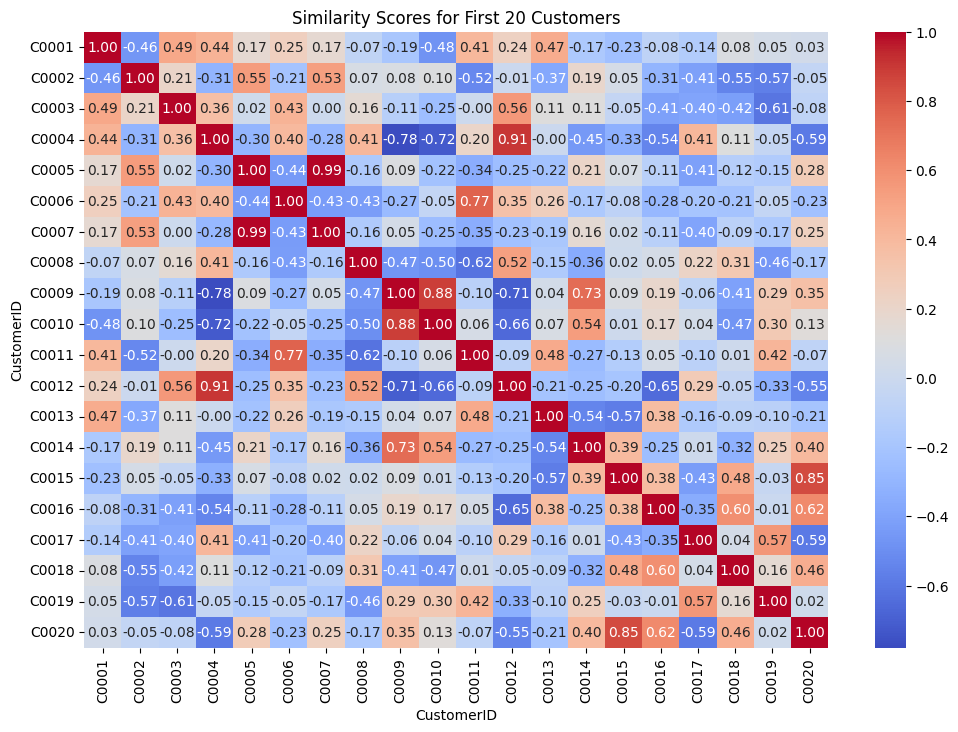

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_df.iloc[:20, :20], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Similarity Scores for First 20 Customers")
plt.xlabel("CustomerID")
plt.ylabel("CustomerID")
plt.show()


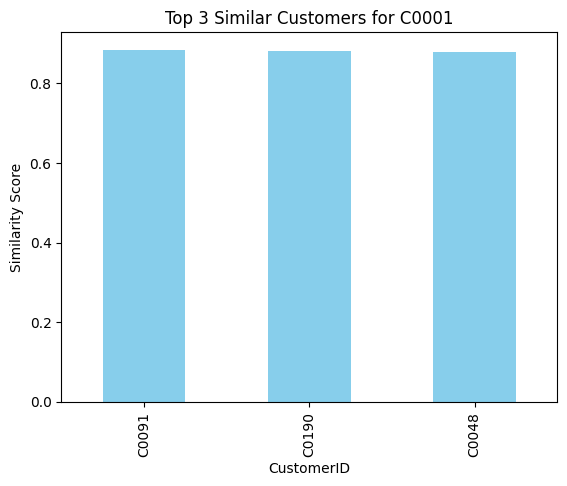

In [ ]:
def plot_customer_similarity(customer_id):
    similar_customers = similarity_df.loc[customer_id].sort_values(ascending=False)[1:4]
    similar_customers.plot(kind="bar", color="skyblue")
    plt.title(f"Top 3 Similar Customers for {customer_id}")
    plt.xlabel("CustomerID")
    plt.ylabel("Similarity Score")
    plt.show()

# Example: Plot similarity for C0001
plot_customer_similarity("C0001")
